In [1]:
import numpy as np
import hera_cal.redcal as rc
import matplotlib.pyplot as plt
import scipy.cluster
from scipy import constants, signal
import scipy
import linsolve

%matplotlib inline 

# Settings

In [2]:
hexnum = 5
min_ubl_per_orient = 4
freqs = np.linspace(.1,.2,128) # in GHz
coarse_Du_target = .5
u_coverage_min = 2
beam_window_target = 5 # in units of wavelengths

In [3]:
uc_kwargs = {'u_coverage_min': u_coverage_min, 'coarse_Du_target': coarse_Du_target, 'beam_window_target': beam_window_target}
chans = {n: freq for n,freq in enumerate(freqs)}
freqs = np.array(sorted(chans.values()))
c = constants.c / 1e9 # in m/ns

# Figure out which orientations to consider

In [4]:
def build_hex_array(hexNum, sep=14.7):
    antpos, i = {}, 0
    for row in range(hexNum-1,-(hexNum),-1):
        for col in range(2*hexNum-abs(row)-1):
            xPos = ((-(2*hexNum-abs(row))+2)/2.0 + col)*sep;
            yPos = row*sep*3**.5/2;
            antpos[i] = np.array([xPos, yPos, 0])
            i += 1
    return antpos

In [5]:
def Get_Unique_Orientations(pos, pos_reds, min_ubl_per_orient = 0):
    """TODO: Document"""
    ubl_pairs = [red[0] for red in pos_reds]
    ubl_pairs = [bl for length,bl in sorted(zip([np.linalg.norm(pos[i] - pos[j]) for (i,j) in ubl_pairs], ubl_pairs))]
    ors = [(pos[i] - pos[j])/np.linalg.norm(pos[i] - pos[j]) for (i,j) in ubl_pairs]

    clusters = scipy.cluster.hierarchy.fclusterdata(ors,1e-10, criterion='distance')
    uors = [[] for i in range(np.max(clusters))]
    for cluster, bl in zip(clusters,ubl_pairs):
        uors[cluster-1].append(bl)
    uors = [uor for uor in uors if len(uor) > min_ubl_per_orient]
    return uors

pos = build_hex_array(hexnum)
pos_reds = rc.get_pos_reds(pos)
uors = Get_Unique_Orientations(pos, pos_reds, min_ubl_per_orient = min_ubl_per_orient)

## Plotting

3 unique orientations are being used.


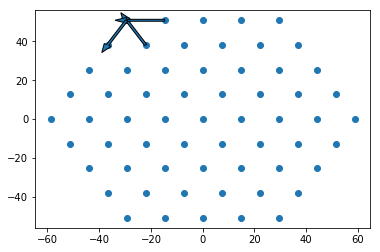

In [6]:
print len(uors), 'unique orientations are being used.'
plt.figure()
plt.scatter(np.array(pos.values())[:,0], np.array(pos.values())[:,1])
ax = plt.axes()
for uor in uors:
    i,j = uor[0]
    ax.arrow(pos[i][0],pos[i][1], pos[j][0]-pos[i][0], pos[j][1]-pos[i][1], width=1)

# Simulate visibilities

In [7]:
class SourceCatalog():
    def __init__(self):
        self.ras, self.decs, self.refFluxes, self.refFreqs, self.alphas = (np.array([]) for i in range(5))
        self.LST = 0.0
    
    def addSource(self, ra, dec, refFlux, refFreq, alpha):
        """Used for manually adding a power-law source by hand."""
        self.ras = np.append(self.ras,ra)
        self.decs = np.append(self.decs,dec)
        self.refFluxes = np.append(self.refFluxes,refFlux)
        self.refFreqs = np.append(self.refFreqs,refFreq)
        self.alphas = np.append(self.alphas,alpha)

    def update_horizontal_coords(self, LST, arrayLatInRad = -0.53619181096511):
        """ Convert RAs and Decs in radians to altitudes and azimuths in radians, given an LST and array location in the specs object """
        self.LST = LST
        RAs = self.ras*np.pi/180. #convert to radians
        decs = self.decs*np.pi/180.
        lha = np.pi/12.0*self.LST - RAs #local hour angle
        self.alts = np.arcsin(np.sin(arrayLatInRad) * np.sin(decs) + np.cos(arrayLatInRad) * np.cos(decs) * np.cos(lha))
        self.azs = np.arctan2( np.sin(lha) * np.cos(decs), np.cos(lha) * np.cos(decs) * np.sin(arrayLatInRad) - np.sin(decs) * np.cos(arrayLatInRad)) + np.pi
        self.carts = np.array([np.sin(self.azs)*np.cos(self.alts), np.cos(self.azs)*np.cos(self.alts), np.sin(self.alts)])
    
    def visibilities(self, baseline, freqs, beamSize = 30.0):
        """baseline = [x,y,z]"""
        sigmas = beamSize*2.*np.pi/360./2.355 *(freqs/.150)**-1.
        fluxes = np.array([self.refFluxes * (freq/self.refFreqs)**(-0*self.alphas) for freq in freqs])
        # NOTE: For now, not including spectral indicies
        beams = np.array([(self.alts > 0) * np.exp(-(np.pi/2.-self.alts)**2./(2.*sigma**2)) for sigma in sigmas])
        beams = np.ones_like(beams)
        # NOTE: For now, I'm using unit beams
        exponents = np.array([np.exp(-2.0j*np.pi/(c/freq)*baseline.dot(self.carts)) for freq in freqs])
        visibility = np.sum(fluxes * beams * exponents, axis=1)
        return visibility

In [8]:
sc = SourceCatalog()
sc.addSource(10,-30,10,.15,.6)
sc.addSource(0,-35,20,.15,.6)
sc.addSource(20,-25,15,.15,.6)
sc.update_horizontal_coords(LST = 0)

In [9]:
true_vis = {}
for uor in uors:
    for bl in uor:
        bl_vec = pos[bl[0]] - pos[bl[1]]
        vis = sc.visibilities(bl_vec, freqs, beamSize = 30.0)
        for findex, chan in enumerate(sorted(chans.keys())):
            true_vis[(bl,chan)] = vis[findex]

## Plotting

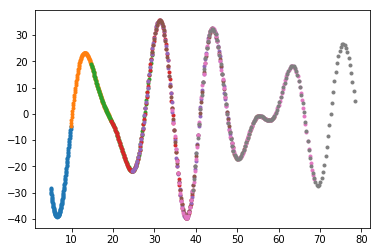

In [10]:
plt.figure()
for bl in uors[0]:
    u = np.linalg.norm(pos[bl[0]] - pos[bl[1]]) / (c / freqs)
    plt.plot(u, np.real([true_vis[(bl,chan)] for chan in chans.keys()]),'.')# * (freqs/.15)**.6,'.')

# Build up geometric information about all orientations

In [11]:
def Compute_Fine_u_Grid(bl_len_dict, chans, beam_window):
    '''TODO: document'''
    freqs = sorted(chans.values())
    shortest_bl = np.min(bl_len_dict.values())
    longest_bl = np.max(bl_len_dict.values())

    df = np.median(np.ediff1d(freqs))
    # TODO: this may not be right...need to reconsider for split hex...may need to be finer spacing        
    fine_Du = np.linalg.norm(shortest_bl) / (constants.c / (1e9 * df))
    fine_us = np.arange(0.0, longest_bl/(c/freqs[-1]) + beam_window, fine_Du)
    return fine_us, fine_Du


def Compute_u_Coverage(bl_len_dict, chans, us):
    '''TODO: document'''
    Du = us[1] - us[0]
    freqs = sorted(chans.values())
    coverage = np.zeros_like(us)
    for bl_len in bl_len_dict.values():
        uMin = bl_len / (constants.c / (1e9*freqs[0]))
        uMax = bl_len / (constants.c / (1e9*freqs[-1]))
        coverage += 1.0 * (us >= uMin) * (us < uMax)    
    return dict(zip(us, coverage))

def Determine_bl_chan_Pairs(bl_len_dict, chans, fine_Du, u_coverage_dict, u_coverage_min = 2):
    '''TODO: document'''
    bl_chan_pairs = {}
    for bl, bl_len in bl_len_dict.items():
        for chan, freq in chans.items():
            u = int(np.round((bl_len / (constants.c / (1e9*freq))) / fine_Du)) * fine_Du
            if u_coverage_dict.has_key(u):
                if u_coverage_dict[u] > u_coverage_min:
                    bl_chan_pairs[(bl,chan)] = u                    
            else:
                raise KeyError('Cannot find u = ' + str(u) + ' in coverage dict.')
    return bl_chan_pairs

def Find_Closest_N_Coarse_us(u, coarse_us, N):
    '''TODO: document'''
    return np.array(sorted([coarse_u for (diff,coarse_u) in sorted(zip(np.abs(coarse_us-u),coarse_us))[0:N]]))
        

class uCal_Orientation:
    
    def __init__(self, bls, pos, chans, u_coverage_min = 2, coarse_Du_target = .5, beam_window_target = 5):
        '''TODO: Document'''
        self.bls = bls
        self.u_coverage_min, self.coarse_Du_target, self.beam_window_target = u_coverage_min, coarse_Du_target, beam_window_target
        
        self.bl_len_dict = {bl: np.linalg.norm(pos[bl[0]] - pos[bl[1]]) for bl in self.bls}
        # Maps bl index pair to baseline length
        fine_us, self.fine_Du = Compute_Fine_u_Grid(self.bl_len_dict, chans, beam_window_target)
        fine_u_coverage = Compute_u_Coverage(self.bl_len_dict, chans, fine_us)
        self.u_coverage_dict = dict(zip(fine_us, fine_u_coverage)) 
        # Maps fine_u to number of baselines that overlap with it

        self.fine_per_coarse = 2*int(np.round(coarse_Du_target / 2 / self.fine_Du)) - 1
        self.coarse_Du = self.fine_per_coarse*self.fine_Du
        self.beam_bins = (2*int(np.ceil((beam_window_target-self.coarse_Du) / (2*self.coarse_Du))) + 1)
        coarse_us = fine_us[0::self.fine_per_coarse]
        coarse_u_included = [np.any(np.abs(u-fine_us[fine_u_coverage >= u_coverage_min]) 
                             <= self.coarse_Du * self.beam_bins) for u in coarse_us]
        self.coarse_us = coarse_us[coarse_u_included]
        
        self.bl_chan_pairs = Determine_bl_chan_Pairs(self.bl_len_dict, chans, self.fine_Du, self.u_coverage_dict, u_coverage_min = u_coverage_min)
        # Maps all included bl_chan_pairs to their fine_u value
        self.nearest_coarse_us = {u: Find_Closest_N_Coarse_us(u, self.coarse_us, self.beam_bins) for u in self.bl_chan_pairs.values()}
        # Maps fine u to the closest coarse u bins
        self.fine_offset = {u: int(np.round((u - self.nearest_coarse_us[u][(self.beam_bins-1)/2]) / self.fine_Du)) for u in self.bl_chan_pairs.values()}
        # maps fine u to how many fine u bins its offset from the nearest coarse bin (the center bin in self.nearest_coarse_us)



# Build the uCal model

In [24]:

def FourierInterpolate(toInterp, factor):
    """Takes some evenly spaced function and returns a Fourier interpolation of that function at the fine_per_coarse level."""
    pad = factor/2
    toPad = np.fft.fftshift(np.fft.fft(toInterp))
    padded = np.concatenate((np.zeros(int(np.ceil(len(toInterp)*pad+.5))), toPad, np.zeros(int(np.floor(len(toInterp)*pad-.5)))))
    interpolated = np.roll((2*pad+1)*np.fft.ifft(np.fft.fftshift(padded)),int(np.floor(pad)))
    return interpolated




class uCal_Model:
    
    def __init__(self, unique_ors, pos, chans, **kwargs):
        '''TODO: Document'''
        self.chans = chans
        self.ornts = [uCal_Orientation(uor, pos, chans, **kwargs) for uor in unique_ors]
        self.model_to_bl_chan, self.bl_chan_to_model = {}, {}
        self.Fourier_Coeffs = {}
        
    def Report_Equation_Summary(self):
        '''TODO: Document'''
        chansUsed = sorted(list(set([chan for uCal_or in self.ornts for (bl,chan) in uCal_or.bl_chan_pairs.keys()])))
        nus = [len(set([u for nearest in uCal_or.nearest_coarse_us.values() for u in nearest])) for uCal_or in self.ornts]
        neq = [len(uCal_or.bl_chan_pairs) for uCal_or in self.ornts]
        print 'There are ' + str(len(chansUsed)) + ' channels and ' + str(np.sum(nus)) + ' coarse u bins. There are ' + str(np.sum(neq)) + ' unique visibilitiy equations.'

    def Build_Model_String_0th_Order(self, or_index, bl, chan):
        '''TODO: Document'''
        ornt = self.ornts[or_index]
        u = ornt.bl_chan_pairs[(bl,chan)]
        nearest = ornt.nearest_coarse_us[u]
        coarse_u = nearest[(len(nearest)-1)/2]
        model_str = ('or' + str(or_index) + 'u' + str(coarse_u)).replace('.','_')
        self.model_to_bl_chan[model_str] = (bl,chan)
        self.bl_chan_to_model[(bl,chan)] = model_str
        return model_str

        
    def Build_Model_String_Linear(self, or_index, bl, chan):
        '''TODO: Document'''
        ornt = self.ornts[or_index]
        u = ornt.bl_chan_pairs[(bl,chan)]
        nearest = ornt.nearest_coarse_us[u]
        offset = ornt.fine_offset[u]
        ratio1 = 1.0*(ornt.fine_per_coarse - np.abs(offset))/ornt.fine_per_coarse
        coarse_u = nearest[(len(nearest)-1)/2]
        term1 = ('or' + str(or_index) + 'u' + str(coarse_u)).replace('.','_')
        ratio2 = 1.0*(np.abs(offset))/ornt.fine_per_coarse
        if offset < 0:
            coarse_u2 = nearest[(len(nearest)-1)/2 - 1]
        else:
            coarse_u2 = nearest[(len(nearest)-1)/2 + 1]
        term2 = ('or' + str(or_index) + 'u' + str(coarse_u2)).replace('.','_')
        model_str = str(ratio1) + '*' + term1 + ' + ' + str(ratio2) + '*' + term2
        self.model_to_bl_chan[model_str] = (bl,chan)
        self.bl_chan_to_model[(bl,chan)] = model_str
        return model_str
    
    
    def Fourier_Interp_Coeffs(self, chan, beam_bins, offset, fine_per_coarse):
        '''TODO: Document'''        
        if not self.Fourier_Coeffs.has_key((beam_bins, offset)):
            coeffs = np.zeros(beam_bins)
            coarse_taper = signal.gaussian(beam_bins, beam_bins/8.0)
            for n in range(beam_bins):
                to_interp = np.zeros(beam_bins, dtype=complex)
                to_interp[n] = 1.0 + 0.0j
                interpolated = FourierInterpolate(to_interp * coarse_taper, fine_per_coarse)
                fine_taper = signal.gaussian(len(interpolated),len(interpolated)/8.0)
                interpolated /= (fine_taper * np.mean(coarse_taper) / np.mean(fine_taper))
                coeffs[n] = interpolated[((fine_per_coarse) * beam_bins) / 2 + offset]
            self.Fourier_Coeffs[(beam_bins, offset)] = coeffs
        return self.Fourier_Coeffs[(beam_bins, offset)]
        
        
    def Build_Model_String_Fourier(self, or_index, bl, chan):
        '''TODO: Document'''
        ornt = self.ornts[or_index]
        u = ornt.bl_chan_pairs[(bl,chan)]
        nearest = ornt.nearest_coarse_us[u]
        coeffs = self.Fourier_Interp_Coeffs(chan, ornt.beam_bins, ornt.fine_offset[u], ornt.fine_per_coarse)
        variables = ['or' + str(or_index) + 'u' + str(coarse_u).replace('.','_') for coarse_u in ornt.nearest_coarse_us[u]]        
        model_str = ' + '.join([str(coeff) + '*' + var for coeff,var in zip(coeffs, variables)])
        self.model_to_bl_chan[model_str] = (bl,chan)
        self.bl_chan_to_model[(bl,chan)] = model_str
        return model_str

uc = uCal_Model(uors, pos, chans, **uc_kwargs)
uc.Report_Equation_Summary()



There are 128 channels and 558 coarse u bins. There are 3012 unique visibilitiy equations.


In [25]:
data = {}
for or_index, ornt in enumerate(uc.ornts):
    for (bl,chan) in ornt.bl_chan_pairs.keys():
#        data[uc.Build_Model_String_0th_Order(or_index, bl, chan)] = true_vis[(bl,chan)]
#        data[uc.Build_Model_String_Linear(or_index, bl, chan)] = true_vis[(bl,chan)]
        data[uc.Build_Model_String_Fourier(or_index, bl, chan)] = true_vis[(bl,chan)]
       

/Users/jsdillon/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:73: ComplexWarning: Casting complex values to real discards the imaginary part


In [26]:
ls = linsolve.LinearSolver(data, sparse=True)
sol = ls.solve()

fine bins per coarse bin:  [11, 11, 11]
coarse bins per beam window :  [13, 13, 13]


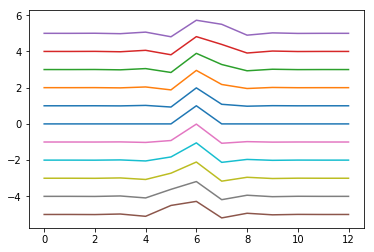

In [27]:
print 'fine bins per coarse bin: ', [ornt.fine_per_coarse for ornt in uc.ornts]
print 'coarse bins per beam window : ', [ornt.beam_bins for ornt in uc.ornts]
plt.figure()
for key,val in uc.Fourier_Coeffs.items():
    plt.plot(val+key[1])

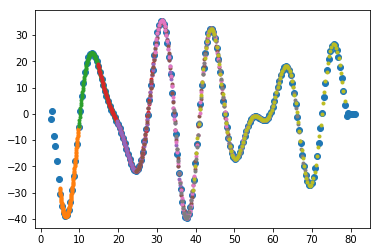

In [28]:
or_index = 0
sol_keys = sol.keys()
us = [float(key.split('or' + str(or_index) + 'u')[-1].replace('_','.')) for key in sol_keys if ('or' + str(or_index)) in key]
vals = [sol[key] for key in sol_keys if ('or' + str(or_index)) in key]

plt.figure()
plt.plot(us, np.real(vals),'o')
for bl in uc.ornts[or_index].bls:
    u = np.linalg.norm(pos[bl[0]] - pos[bl[1]]) / (c / freqs)
    plt.plot(u, np.real([true_vis[(bl,chan)] for chan in chans.keys()]),'.')# * (freqs/.15)**.6,'.')a


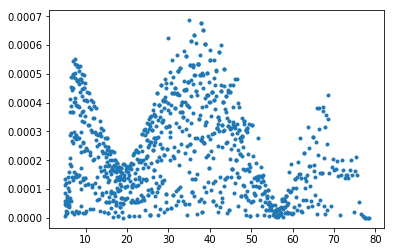

In [29]:
or_index = 0
ornt = uc.ornts[or_index]
model_to_vissol = {eq.val: eq.eval(sol) for eq in ls.eqs}

vissols = np.array([model_to_vissol[uc.bl_chan_to_model[(bl,chan)]] for bl,chan in ornt.bl_chan_pairs.keys()])
truevis = np.array([true_vis[(bl,chan)] for bl,chan in ornt.bl_chan_pairs.keys()])
us = ornt.bl_chan_pairs.values()

plt.figure()
plt.plot(us,np.abs(vissols-truevis),'.')
#plt.plot(us,np.real(truevis),'.')
#plt.plot(us,np.real(vissols),'.')

## Gameplan:

* ~~No bandpass, linsolver, nearest coarse bin~~
* ~~No bandpass, linsolver, linear interpolation~~
* ~~No bandpass, linsolver, fourier interpolation~~
* No bandpass, linsolver, gaussian beam, gaussian sum 
* With bandpass, linproductsolver, gaussian beam, gaussian sum
* With bandpass, linproductsolver, gaussian beam, gaussian sum, polynomials in log(freq)
* Realistic beams???

Still to figure out...what do we do with the width? Do we fit that separately?

# Iteratively solve for uCal parameters

In [18]:
# plt.figure()
# plt.plot(uCal_ors[0].fine_us, uCal_ors[0].fine_u_coverage,'.')
# plt.plot(uCal_ors[0].coarse_us, 2.5*np.ones_like(uCal_ors[0].coarse_us),'.')

In [19]:
# plt.figure()
# bl = uors[0][0]
# bl_vec = pos[bl[0]] - pos[bl[1]]
# fine_u_freqs = 1e-9 * constants.c  * (np.linalg.norm(bl_vec) / uCal_ors[0].fine_us[1:])**-1
# fine_vis = sc.visibilities(bl_vec, fine_u_freqs, beamSize = 30.0)
# plt.plot(uCal_ors[0].fine_us[1:], np.real(fine_vis),'.')

# coarse_u_freqs = 1e-9 * constants.c  * (np.linalg.norm(bl_vec) / uCal_ors[0].coarse_us)**-1
# coarse_vis = sc.visibilities(bl_vec, coarse_u_freqs, beamSize = 30.0)
# coarse_vis = {u:vis for u,vis in zip(uCal_ors[0].coarse_us, coarse_vis)}


# # for bl in uors[0]:
# #     u = np.linalg.norm(pos[bl[0]] - pos[bl[1]]) / (((constants.c) / 1e9) / freqs)
# #     plt.plot(u, np.real(true_vis[bl]),'.')

# plt.plot(coarse_vis.keys(), coarse_vis.values(),'.')

In [20]:
# scipy.signal.gaussian(11,11/8.0)

In [21]:
# #TODO: add windowing function to interpolator

# def interpolator(fine_u, coarse_vis, fine_Du, coarse_Du, beam_window, fine_per_coarse, gaussSize=8.0):
#     window_coarse_bins = int(np.round(beam_window/coarse_Du))
#     coarse_us = Find_Closest_N_Coarse_us(fine_u, coarse_vis.keys(), int(np.round(beam_window/coarse_Du)))
#     offset = int(np.round((fine_u - coarse_us[(window_coarse_bins-1)/2])/fine_Du))
    
    
    
#     vis = np.array([coarse_vis[u] for u in coarse_us])
#     coarse_window = scipy.signal.gaussian(len(vis),len(vis)/gaussSize)
#     interpolatedVis = FourierInterpolate(coarse_window*vis, fine_per_coarse/2)
#     fine_window = scipy.signal.gaussian(len(interpolatedVis),len(interpolatedVis)/gaussSize)
#     interpolatedVis /= (fine_window * np.mean(coarse_window) / np.mean(fine_window))

#     return interpolatedVis[fine_per_coarse*window_coarse_bins/2+offset]
    

In [22]:
# ornt = uc.ornts[0]

# us = ornt.fine_us[300:1800]

# # plt.figure()
# # plt.plot(us, interpolated,'.-')
# # plt.plot(coarse_vis.keys(), coarse_vis.values(),'.',ms=10)

# plt.figure()
# interpolated = np.array([interpolator(u, coarse_vis, ornt.fine_Du, ornt.coarse_Du, ornt.beam_window, ornt.fine_per_coarse) for u in us])
# plt.semilogy(us, np.abs(fine_vis[299:1799]-interpolated))

In [23]:
# uc.ornts[0].nearest_coarse_us.keys()[0]